In [2]:
# Bibliotecas
import pandas as pd
import networkx as nx
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import dotenv
import os

In [3]:
# Conexão Banco
dotenv.load_dotenv()
db_url = os.getenv("db_url")

In [4]:
# QUERY: Produto vs Produto Similar

engine = create_engine(db_url)

 
with engine.connect() as conn:
    print("Conexão realizada com sucesso!")

    query = text(f'''
                    select 
                    p."Partnumber" as "PN",
                    m2."Nome" as "MARCA",
                    m2."Nome" || p."Partnumber" as "MARCA_PN",
                    gp."Nome" as "GRUPO_PRODUTO",
                    ps."Partnumber" as "PN_CROSS",
                    m."Nome" as "MARCA_CROSS",
                    m."Nome" || ps."Partnumber" as "MARCA_PN_CROSS"
                    from "Produto" p
                    left join "ProdutoSimilar" ps on ps."ProdutoId" = p."Id"
                    left join "Marca" m on m."Id" = ps."MarcaId"
                    left join "Marca" m2 on m2."Id" = p."MarcaId"
                    left join "ProdutoAplicacao" pa on p."Id" = pa."ProdutoId"
                    left join "GrupoProduto" gp on gp."Id" = pa."GrupoProdutoId"
                    where gp."Nome" = 'Pastilha de Freio'
                    and p."StatusId" = 1
                ''')
    
    similares = pd.read_sql_query(query, conn)
    print('Partnumbers extraidos')

Conexão realizada com sucesso!
Partnumbers extraidos


In [3]:
# Filtrando cross que estão cadastrados no banco
similares_filter = similares[similares['MARCA_PN_CROSS'].isin(similares['MARCA_PN'].unique())]

In [23]:
# Grafos

# Criar o grafo direcionado
G = nx.DiGraph()
for _, row in similares_filter.iterrows():
    G.add_edge(row['MARCA_PN'], row['MARCA_PN_CROSS'], weight=1)

# Encontrar as famílias com base em conexões fracas
#families = list(nx.weakly_connected_components(G))

# Encontrar as famílias com base em conexões fortes
families = list(nx.strongly_connected_components(G))

# Associar cada produto ao seu respectivo código de família
product_to_family = {}
for family_id, family in enumerate(families, start=1):
    for product in family:
        product_to_family[product] = family_id

# Função para calcular métricas e grau de pertencimento dentro da família
def calculate_membership_score(subgraph):
    # Calcular as centralidades
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph, normalized=True)

    # Encontrar os valores máximos para normalizar
    max_deg = max(degree_centrality.values()) if degree_centrality else 1
    max_clo = max(closeness_centrality.values()) if closeness_centrality else 1
    max_bet = max(betweenness_centrality.values()) if betweenness_centrality else 1

    # Listar os resultados
    results = []
    for node in subgraph.nodes():
        # Normalizar cada métrica
        norm_deg = degree_centrality[node] / max_deg if max_deg != 0 else 0
        norm_clo = closeness_centrality[node] / max_clo if max_clo != 0 else 0
        norm_bet = betweenness_centrality[node] / max_bet if max_bet != 0 else 0

        results.append((node, norm_deg, norm_clo, norm_bet))
    
    return results

# Montar os dados finais
data = []
for family_id, family in enumerate(families, start=1):
    subgraph = G.subgraph(family)
    centralities = calculate_membership_score(subgraph)
    for product, norm_deg, norm_clo, norm_bet in centralities:
        data.append([product, family_id, norm_deg, norm_clo, norm_bet])

# Criar o DataFrame final
membership_df = pd.DataFrame(data, columns=[
    'partnumber',
    'familia',
    'centralidade_grau', #Mede a quantidade de conexões diretas de um nó. GRAU(nó1) = nº de arestas(nó1) / maior nº de arestas em um dos nós
    'centralidade_proximidade', #Mede a proximidade de um nó a todos os outros nós do grafo. PROXIMIDADE(nó1) = 1 / soma da menor distancia do nó1 para cada um dos outros
    'centralidade_intermediacao', #Mede a quantidade de vezes que um nó atua como intermediário. INTERMEDIACAO(nó1) = nº de caminhos entre nó2 e nó3 / nº de caminhos entre nó2 e nó3 que passam por nó1  
])

membership_df['pertencimento'] = membership_df.apply(
    lambda row: (sorted([row['centralidade_grau'], row['centralidade_proximidade'], row['centralidade_intermediacao']], reverse=True)[0] + 
                sorted([row['centralidade_grau'], row['centralidade_proximidade'], row['centralidade_intermediacao']], reverse=True)[1])/2,
    axis=1
)


In [ ]:
#Verificações de familias e produtos

relevancia = 3
qtd_itens_familia = membership_df.groupby(['Código da Família'])['Produto'].count().reset_index().rename(columns={'Produto':'qtd itens'}) 
qtd_familias_por_qtd_itens = qtd_itens_familia.groupby('qtd itens')['Código da Família'].count().reset_index().rename(columns={'Código da Família':'n familias'}) 
familias_relevantes = qtd_itens_familia[qtd_itens_familia['qtd itens'] > relevancia]
produtos_em_familias_relevantes = qtd_familias_por_qtd_itens[qtd_familias_por_qtd_itens['qtd itens'] > relevancia]

print(f"{sum(produtos_em_familias_relevantes['qtd itens'] * produtos_em_familias_relevantes['n familias'])} itens estão em familias com mais de 3 itens de um total de {len(membership_df)} itens.")

qtd_cross = similares_filter.groupby('MARCA_PN')['MARCA_PN_CROSS'].count().reset_index().rename(columns={'MARCA_PN_CROSS':'QTD SIMILARES'}).sort_values(by='QTD SIMILARES', ascending=False)


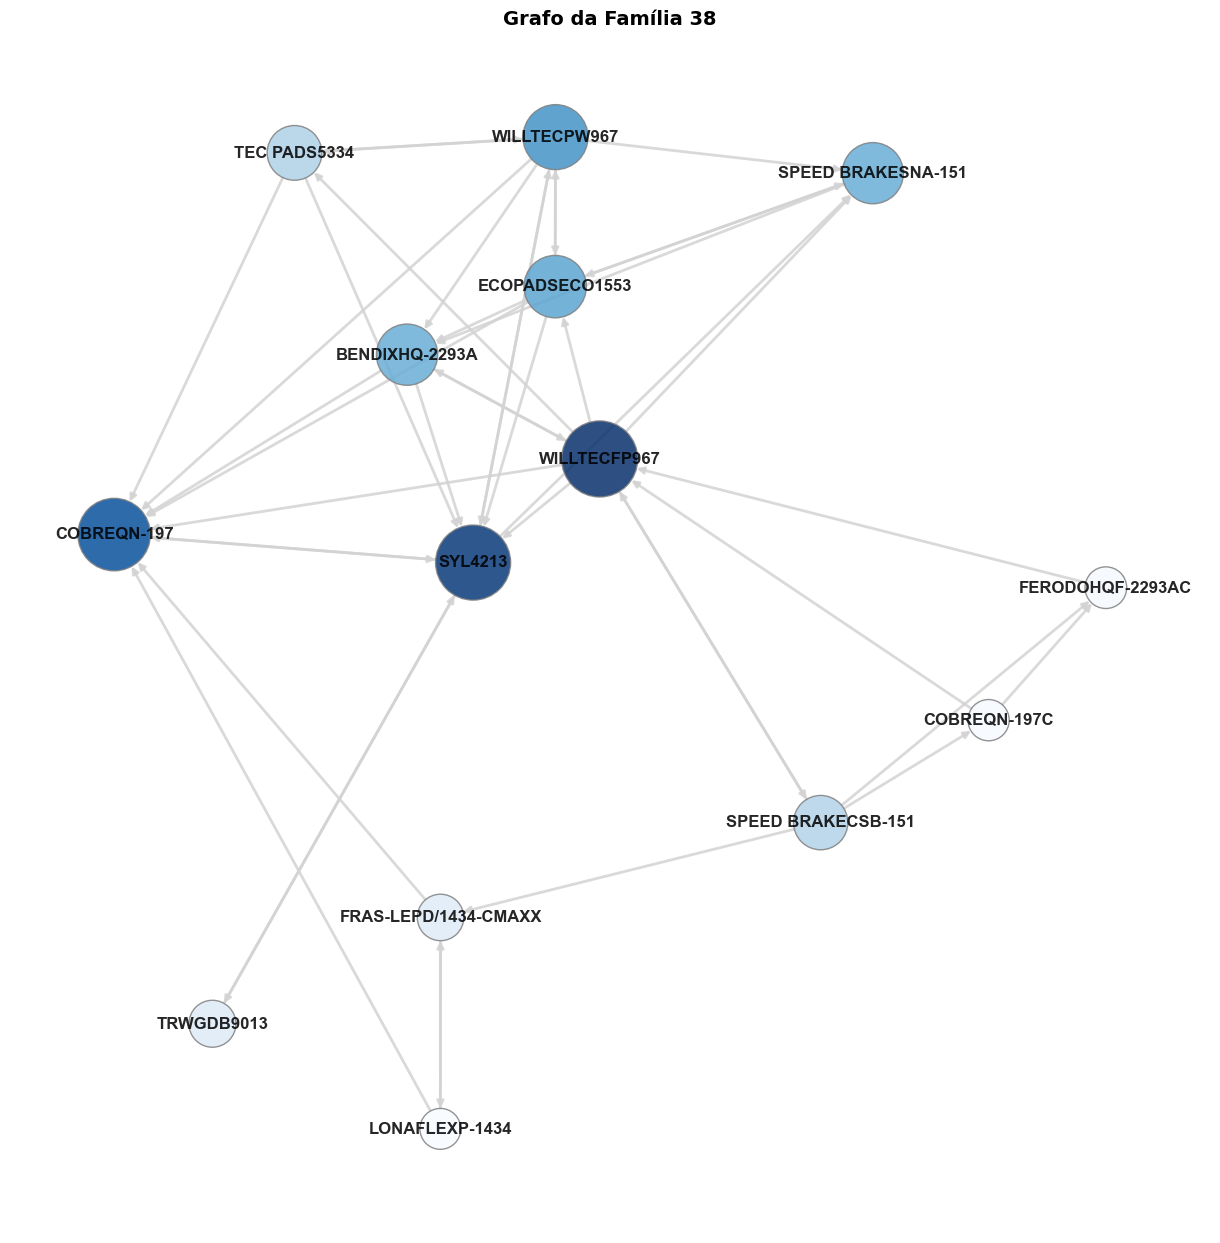

In [44]:
#Visualizar grafos de uma familia especifica

def visualizar_familia(family_id_escolhido):
    # Encontrar os produtos da família escolhida
    produtos_da_familia = [p for p, f in product_to_family.items() if f == family_id_escolhido]

    # Criar subgrafo da família
    subgraph = G.subgraph(produtos_da_familia)

    # Calcular o grau de pertencimento para cada nó (produto) da família
    perten = membership_df[membership_df['familia'] == family_id_escolhido]
    perten_dict = dict(zip(perten['partnumber'], perten['pertencimento']))

    # Layout para posicionamento dos nós (mais moderno)
    pos = nx.spring_layout(subgraph, seed=42, k=0.2, iterations=30)  # Ajuste o 'k' e 'iterations' para mais controle sobre o layout

    # Tamanho dos nós proporcional ao grau de pertencimento
    node_sizes = [3000 * perten_dict.get(n, 0) for n in subgraph.nodes()]

    # Cor dos nós proporcional ao grau de pertencimento
    node_colors = [perten_dict.get(n, 0) for n in subgraph.nodes()]

    # Desenho do grafo mais minimalista e limpo
    plt.figure(figsize=(12, 12))

    # Desenhar o grafo
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_size=node_sizes,
        node_color=node_colors,
        cmap='Blues',  # Usando uma paleta de cores mais suave
        edge_color='lightgray',  # Cor das arestas mais neutra
        font_size=12,
        font_weight='bold',
        font_color='black',
        width=2,  # Arestas mais grossas para maior visibilidade
        alpha=0.85,  # Um toque de transparência para suavizar a visualização
        edgecolors='grey',  # Cor das bordas dos nós para destacarselect * from
        linewidths=1,
        font_family='Arial',  # Fonte moderna
    )

    # Adicionar título com estilo mais clean
    plt.title(f"Grafo da Família {family_id_escolhido}", fontsize=14, fontweight='bold')

    # Remover os eixos para uma visualização mais limpa
    plt.axis('off')

    # Exibir o gráfico
    plt.show()

# Exemplo de uso:
familia = 38
visualizar_familia(familia) 

In [45]:
membership_df[membership_df['familia']==familia].sort_values(by='pertencimento', ascending=False)

,partnumber,familia,centralidade_grau,centralidade_proximidade,centralidade_intermediacao,pertencimento
87,WILLTECFP967,38,1.000000,0.529412,1.000000,1.000000
90,SYL4213,38,1.000000,0.947368,0.708595,0.973684
95,COBREQN-197,38,0.818182,1.000000,0.276730,0.909091
88,WILLTECPW967,38,0.818182,0.642857,0.415094,0.730519
98,ECOPADSECO1553,38,0.727273,0.620690,0.054507,0.673981
91,BENDIXHQ-2293A,38,0.636364,0.642857,0.654088,0.648473
96,SPEED BRAKESNA-151,38,0.545455,0.750000,0.226415,0.647727
92,TEC PADS5334,38,0.454545,0.580645,0.016771,0.517595
93,SPEED BRAKECSB-151,38,0.454545,0.391304,0.566038,0.510292
89,TRWGDB9013,38,0.181818,0.580645,0.000000,0.381232


In [53]:
# QUERY: Produto Aplicação

interesse = membership_df[membership_df['familia'] == familia]['partnumber'].unique()
interesse_list = sorted(list(interesse))
interesse_tuple = tuple(interesse_list)

db_url = 'postgresql+psycopg2://fraga:0Ce*O}KLn?/S`V"c@rpl.database.prd.intelliauto.com.br:5432/fragaDb'

engine = create_engine(db_url)

 
with engine.connect() as conn:
    print("Conexão realizada com sucesso!")

    query = text(f'''
                    select m."Nome" || p."Partnumber" as "MARCA_PN", v."CodigoFraga"  from "ProdutoAplicacaoVeiculos" pav
                    left join "ProdutoAplicacao" pa on pa."Id" =  pav."ProdutoAplicacaoId"
                    left join "Produto" p on p."Id" =  pa."ProdutoId"
                    left join "Veiculo" v on v."Id" =  pav."VeiculoId"
                    left join "Marca" m on m."Id" =  p."MarcaId"
                    where m."Nome" || p."Partnumber" in {interesse_tuple}
                ''')
    
    veiculos = pd.read_sql_query(query, conn)
    print('Partnumbers extraidos')

Conexão realizada com sucesso!
Partnumbers extraidos


In [72]:
# Aplicacao dos veiculos

veiculos_agrup = veiculos.groupby(['CodigoFraga']).count().reset_index()
total = veiculos_agrup['MARCA_PN'].sum()
veiculos_agrup['percentual'] = veiculos_agrup['MARCA_PN']/total
aplicacao = pd.merge(veiculos, veiculos_agrup[['CodigoFraga', 'percentual']], on = 'CodigoFraga', how='left')
aplicacao_agrup = aplicacao.groupby(['MARCA_PN'])['percentual'].sum().reset_index().rename(columns={'MARCA_PN':'partnumber'})

membership_df_filter = membership_df[membership_df['familia']==familia].sort_values(by='pertencimento', ascending=False)
membership_df_filter = pd.merge(membership_df_filter, aplicacao_agrup, on = 'partnumber', how='left')


In [78]:
membership_df_filter

,partnumber,familia,centralidade_grau,centralidade_proximidade,centralidade_intermediacao,pertencimento,percentual
0,WILLTECFP967,38,1.000000,0.529412,1.000000,1.000000,0.751142
1,SYL4213,38,1.000000,0.947368,0.708595,0.973684,0.710046
2,COBREQN-197,38,0.818182,1.000000,0.276730,0.909091,0.924658
3,WILLTECPW967,38,0.818182,0.642857,0.415094,0.730519,0.751142
4,ECOPADSECO1553,38,0.727273,0.620690,0.054507,0.673981,0.632420
5,BENDIXHQ-2293A,38,0.636364,0.642857,0.654088,0.648473,0.305936
6,SPEED BRAKESNA-151,38,0.545455,0.750000,0.226415,0.647727,0.897260
7,TEC PADS5334,38,0.454545,0.580645,0.016771,0.517595,0.938356
8,SPEED BRAKECSB-151,38,0.454545,0.391304,0.566038,0.510292,0.956621
9,TRWGDB9013,38,0.181818,0.580645,0.000000,0.381232,0.764840


In [ ]:
membership_df[(membership_df['Código da Família']==1) & (membership_df['Grau de Pertencimento']>0.5)].sort_values(by = 'Grau de Pertencimento', ascending=False)